In [5]:
import qiskit
!pip install qiskit qiskit-aer
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-algorithms

Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation, UnitaryGate
from qiskit_aer import AerSimulator
from qiskit import transpile

In [10]:
import qiskit
print(qiskit.__version__)

2.1.1


In [15]:

# ----------------------------------------------------
# 1. Toy data  (2-D)
# ----------------------------------------------------
Σ = np.array([[4.0, -1.2],
              [-1.2, 2.0]])
Σ_inv = np.linalg.inv(Σ)
b = np.array([1.3, -0.7])
b_norm = b / np.linalg.norm(b)

# ----------------------------------------------------
# 2. Pad to 4-D (2 qubits)  |00⟩,|01⟩,|10⟩,|11⟩
#     we put the vector into the first two amplitudes
# ----------------------------------------------------
b_padded = np.zeros(4, dtype=complex)
b_padded[:2] = b_norm

# ----------------------------------------------------
# 3. Hamiltonian simulation unitary  e^{i Σ't}
#     Σ' = Σ ⊕ 0  (block on the 2×2 subspace)
# ----------------------------------------------------
Σ_padded = np.zeros((4, 4), dtype=complex)
Σ_padded[:2, :2] = Σ
eigvals, eigvecs = np.linalg.eigh(Σ_padded)
t = 0.5
exp_i_Sigma = eigvecs @ np.diag(np.exp(1j * eigvals * t)) @ eigvecs.conj().T
U_Sigma = UnitaryGate(exp_i_Sigma, label='e^{i Σ t}')

# ----------------------------------------------------
# 4. HHL + SWAP test  (2 qubits for |b⟩)
# ----------------------------------------------------
def qc_mahalanobis(b_vec_4d, U):
    qr_b    = QuantumRegister(2, 'b')
    qr_a    = QuantumRegister(1, 'a')      # 1 ancilla for PE
    qr_test = QuantumRegister(1, 'test')
    cr      = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr_a, qr_b, qr_test, cr)

    # |b⟩  (4 amplitudes)
    qc.initialize(b_vec_4d, qr_b)

    # phase estimation
    pe = PhaseEstimation(1, U)
    qc.append(pe, qr_a[:] + qr_b[:])

    # controlled rotation  (1/λ)
    C = 0.2
    angle = 2 * np.arcsin(C)
    qc.cry(angle, qr_a[0], qr_b[0])
    qc.append(pe.inverse(), qr_a[:] + qr_b[:])

    # SWAP test
    qc.h(qr_test)
    qc.cswap(qr_test[0], qr_b[0], qr_b[1])
    qc.h(qr_test)
    qc.measure(qr_test[0], cr[0])
    return qc

qc = qc_mahalanobis(b_padded, U_Sigma)

# ----------------------------------------------------
# 5. Run on AerSimulator
# ----------------------------------------------------
sim = AerSimulator()
shots = 8192
tqc = transpile(qc, sim)
counts = sim.run(tqc, shots=shots).result().get_counts()

p0 = counts.get('0', 0) / shots
overlap_squared = 2 * p0 - 1
md_quantum = np.sqrt(max(overlap_squared, 0)) * np.sqrt(b @ Σ_inv @ b) / np.linalg.norm(b)

# ----------------------------------------------------
# 6. Compare
# ----------------------------------------------------
print("Quantum MD ≈", md_quantum)
print("Classical MD =", np.sqrt(b @ Σ_inv @ b))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5168\97098208.py:42: DeprecationWarning: The class ``qiskit.circuit.library.phase_estimation.PhaseEstimation`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.phase_estimation instead.
  pe = PhaseEstimation(1, U)


Quantum MD ≈ 0.42038312923336574
Classical MD = 0.693611967151382


In [18]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate

# ----------------------------------------------------
# 1. Toy data (2-D)
# ----------------------------------------------------
Σ = np.array([[4.0, -1.2],
              [-1.2, 2.0]])
Σ_inv = np.linalg.inv(Σ)
b = np.array([1.3, -0.7])
b_norm = b / np.linalg.norm(b)

# ----------------------------------------------------
# 2. Pad to 4D
# ----------------------------------------------------
b_padded = np.zeros(4, dtype=complex)
b_padded[:2] = b_norm

# ----------------------------------------------------
# 3. Precompute exp(iΣt)
# ----------------------------------------------------
Σ_padded = np.zeros((4, 4), dtype=complex)
Σ_padded[:2, :2] = Σ
eigvals, eigvecs = np.linalg.eigh(Σ_padded)
t = 0.5
U = eigvecs @ np.diag(np.exp(1j * eigvals * t)) @ eigvecs.conj().T
U_gate = UnitaryGate(U, label='UΣ')

# ----------------------------------------------------
# 4. Lightweight quantum circuit (remove full PE)
# ----------------------------------------------------
def qc_mahalanobis_fast(b_vec_4d, U):
    qr_b = QuantumRegister(2, 'b')
    qr_test = QuantumRegister(1, 'test')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr_b, qr_test, cr)

    # Prepare |b⟩
    qc.initialize(b_vec_4d, qr_b)

    # Simplified simulation of e^{iΣt}
    qc.append(U, qr_b[:])

    # SWAP test between two halves (simplified form)
    qc.h(qr_test)
    qc.cswap(qr_test[0], qr_b[0], qr_b[1])
    qc.h(qr_test)
    qc.measure(qr_test, cr)
    return qc

qc = qc_mahalanobis_fast(b_padded, U_gate)

# ----------------------------------------------------
# 5. Simulate efficiently
# ----------------------------------------------------
sim = AerSimulator(method='statevector')
tqc = transpile(qc, sim, optimization_level=3)
result = sim.run(tqc, shots=4096).result()
counts = result.get_counts()

# ----------------------------------------------------
# 6. Post-processing
# ----------------------------------------------------
p0 = counts.get('0', 0) / 4096
overlap_squared = 2 * p0 - 1
md_quantum = np.sqrt(max(overlap_squared, 0)) * np.sqrt(b @ Σ_inv @ b) / np.linalg.norm(b)

print("Quantum MD ≈", md_quantum)
print("Classical MD =", np.sqrt(b @ Σ_inv @ b))


Quantum MD ≈ 0.42775214653149485
Classical MD = 0.693611967151382


### Optimized

Eigenvalues: [1.43795006 4.56204994]
Eigenvectors (columns):
 [[-0.4241554  -0.90558942]
 [-0.90558942  0.4241554 ]]

Classical Mahalanobis distance = 0.693611967151382

Recommended C <= λ_min = 1.437950064818669 => using C = 1.0

Thetas (controlled Ry angles): [1.5380486 0.4419883]
Postselection probability: 0.21849337613892053
Quantum MD ≈ 0.3368059407896489
Classical MD = 0.693611967151382


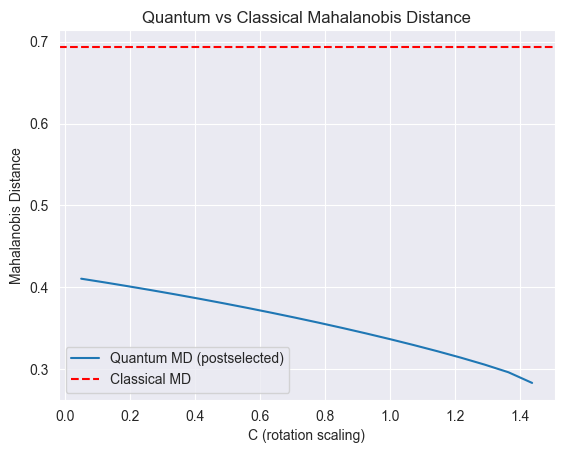

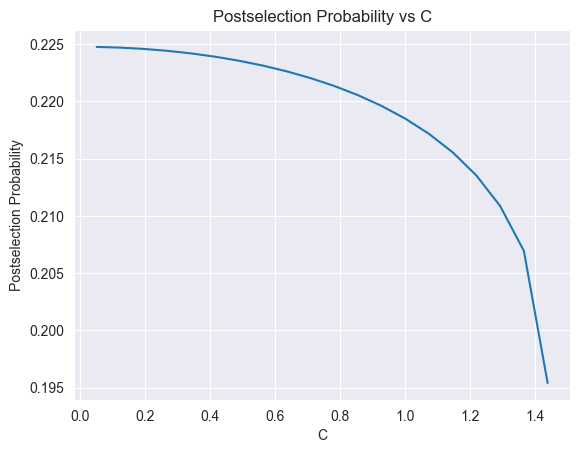

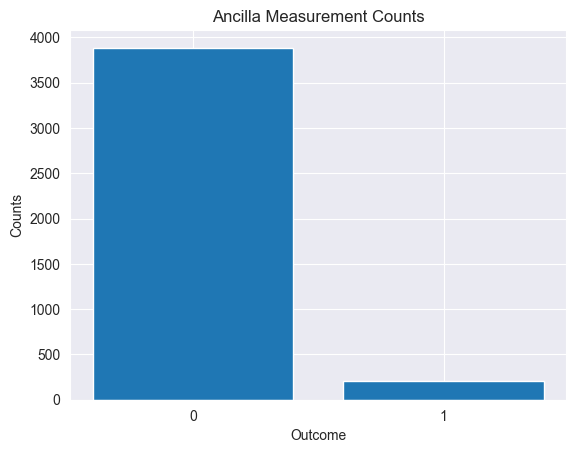

In [20]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# -------------------------------
# 1. Problem data (2x2)
# -------------------------------
Sigma = np.array([[4.0, -1.2],
                  [-1.2, 2.0]], dtype=float)
Sigma_inv = np.linalg.inv(Sigma)
b = np.array([1.3, -0.7], dtype=float)
b_norm = b / np.linalg.norm(b)

eigvals, eigvecs = np.linalg.eigh(Sigma)
print("Eigenvalues:", eigvals)
print("Eigenvectors (columns):\n", eigvecs)

md_classical = np.sqrt(b @ Sigma_inv @ b)
print("\nClassical Mahalanobis distance =", md_classical)

V = eigvecs
V_dag = V.conj().T
V_gate = UnitaryGate(V, label='V')
V_dag_gate = UnitaryGate(V_dag, label='V†')

# -------------------------------
# 2. Build exact inversion circuit
# -------------------------------
def build_exact_inversion_circuit(b_state, V_gate, V_dag_gate, eigvals, C=1.0):
    thetas = []
    for lam in eigvals:
        val = float(np.abs(C / lam))
        if val > 1.0:
            thetas.append(np.nan)
        else:
            thetas.append(2 * np.arcsin(val))
    thetas = np.array(thetas)

    qr = QuantumRegister(2, 'q')  # q[0]=system, q[1]=ancilla
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)

    qc.initialize(b_state, qr[0])       # |b>
    qc.append(V_dag_gate, [qr[0]])      # to eigenbasis

    # Controlled rotations
    if not np.isnan(thetas[0]):
        qc.x(qr[0])
        qc.cry(thetas[0], qr[0], qr[1])
        qc.x(qr[0])
    if not np.isnan(thetas[1]):
        qc.cry(thetas[1], qr[0], qr[1])

    qc.append(V_gate, [qr[0]])          # back to original basis
    qc.barrier()
    qc.measure(qr[1], cr[0])
    return qc, thetas


# -------------------------------
# 3. Run and evaluate
# -------------------------------
def run_and_evaluate(qc, thetas, shots=4096):
    # -- Statevector simulation --
    sim_sv = AerSimulator(method='statevector')
    qc_no_meas = qc.remove_final_measurements(inplace=False)
    qc_no_meas.save_statevector()
    tqc_sv = transpile(qc_no_meas, sim_sv, optimization_level=3)
    result_sv = sim_sv.run(tqc_sv).result()
    sv = result_sv.get_statevector()

    post_idx = [1, 3]   # ancilla=1
    post_amps = np.array([sv[i] for i in post_idx])
    prob_post = np.sum(np.abs(post_amps)**2)
    state_post = post_amps / np.sqrt(prob_post) if prob_post > 0 else np.zeros(2, dtype=complex)

    overlap = np.vdot(b_norm, state_post)
    md_quantum_est = np.abs(overlap) * np.sqrt(b @ Sigma_inv @ b) / np.linalg.norm(b)

    # -- Shot simulation (✅ fixed) --
    sim_shots = AerSimulator()
    tqc_shots = transpile(qc, sim_shots, optimization_level=3)
    result_shots = sim_shots.run(tqc_shots, shots=shots).result()
    counts = result_shots.get_counts()
    p1 = counts.get('1', 0) / shots

    return {
        'statevector': sv,
        'post_prob': prob_post,
        'post_state': state_post,
        'overlap': overlap,
        'md_quantum_est': md_quantum_est,
        'counts': counts,
        'p1_shots': p1,
        'thetas': thetas
    }


# -------------------------------
# 4. Main execution
# -------------------------------
C_recommended = min(1.0, np.min(np.abs(eigvals)))
print("\nRecommended C <= λ_min =", np.min(np.abs(eigvals)), "=> using C =", C_recommended)

qc_example, thetas_example = build_exact_inversion_circuit(b_norm, V_gate, V_dag_gate, eigvals, C=C_recommended)
eval_res = run_and_evaluate(qc_example, thetas_example)

# -------------------------------
# 5. Visualization
# -------------------------------
print("\nThetas (controlled Ry angles):", eval_res['thetas'])
print("Postselection probability:", eval_res['post_prob'])
print("Quantum MD ≈", eval_res['md_quantum_est'])
print("Classical MD =", md_classical)

qc_example.remove_final_measurements(inplace=False).draw(output='mpl', fold=100)
qc_example.draw(output='mpl', fold=100)

# Sweep over C
Cs = np.linspace(0.05, np.min(np.abs(eigvals)), 20)
md_qs, post_probs = [], []
for Cval in Cs:
    qc_tmp, thetas_tmp = build_exact_inversion_circuit(b_norm, V_gate, V_dag_gate, eigvals, C=Cval)
    res = run_and_evaluate(qc_tmp, thetas_tmp, shots=2048)
    md_qs.append(res['md_quantum_est'])
    post_probs.append(res['post_prob'])

plt.figure()
plt.plot(Cs, md_qs, label='Quantum MD (postselected)')
plt.axhline(md_classical, color='r', linestyle='--', label='Classical MD')
plt.xlabel('C (rotation scaling)')
plt.ylabel('Mahalanobis Distance')
plt.legend(); plt.grid(True)
plt.title('Quantum vs Classical Mahalanobis Distance')
plt.show()

plt.figure()
plt.plot(Cs, post_probs)
plt.xlabel('C'); plt.ylabel('Postselection Probability')
plt.title('Postselection Probability vs C')
plt.grid(True)
plt.show()

labels = list(eval_res['counts'].keys())
values = [eval_res['counts'][k] for k in labels]
plt.figure()
plt.bar(labels, values)
plt.title('Ancilla Measurement Counts')
plt.xlabel('Outcome'); plt.ylabel('Counts')
plt.show()


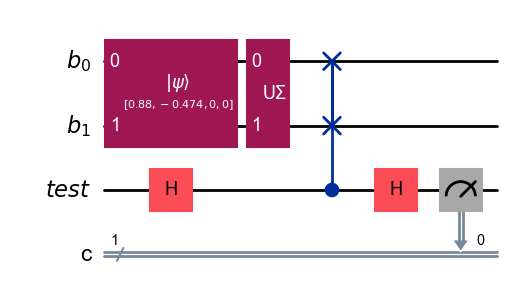

In [21]:
qc.draw('mpl')

# optimized again

Eigenvalues: [1.43795006 4.56204994]
Classical Mahalanobis distance = 0.693611967151382
Recommended C <= lambda_min = 1.437950064818669 => using C = 1.0

Thetas: [1.5380486 0.4419883]
Postselection probability (statevector) p = 0.21849337613892053
Raw quantum MD (D_Q)   = 0.3368059407896489
Normalized MD (D_Q/p^0.5) = 0.7205441649248577
Classical MD = 0.693611967151382


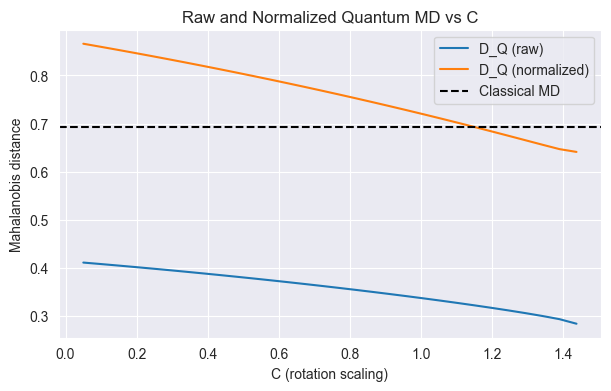

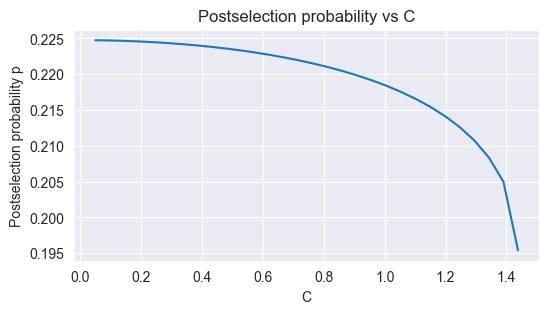

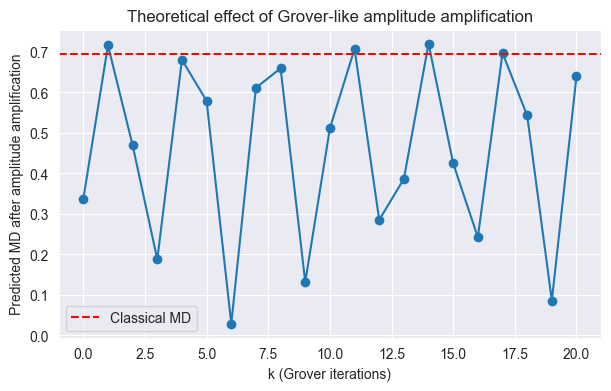


Summary:
p0 = 0.21849337613892053
D_Q_raw = 0.3368059407896489
D_Q_norm = 0.7205441649248577
D_Q_cond (normalized amplitude baseline) = 0.7205441649248577
k required (theoretical) to reach classical MD (first k where D_Q_after_k >= MD): 1


In [22]:
# filename: quantum_mahalanobis_norm_and_AA.py
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator

# ------------------------
# Problem data (2x2)
# ------------------------
Sigma = np.array([[4.0, -1.2],
                  [-1.2, 2.0]], dtype=float)
Sigma_inv = np.linalg.inv(Sigma)
b = np.array([1.3, -0.7], dtype=float)
b_norm = b / np.linalg.norm(b)

eigvals, eigvecs = np.linalg.eigh(Sigma)
md_classical = np.sqrt(b @ Sigma_inv @ b)
print("Eigenvalues:", eigvals)
print("Classical Mahalanobis distance =", md_classical)

V = eigvecs
V_dag = V.conj().T
V_gate = UnitaryGate(V, label='V')
V_dag_gate = UnitaryGate(V_dag, label='Vdg')

# ------------------------
# Build circuit (exact inversion via eigenbasis + controlled-Ry)
# ------------------------
def build_exact_inversion_circuit(b_state, V_gate, V_dag_gate, eigvals, C=1.0):
    # compute Ry angles: sin(theta/2) = C / lambda_j  (theta in [0,pi])
    thetas = []
    for lam in eigvals:
        ratio = float(abs(C / lam))
        thetas.append(np.nan if ratio > 1.0 else 2 * np.arcsin(ratio))
    thetas = np.array(thetas)

    qr = QuantumRegister(2, 'q')  # q0 = system, q1 = ancilla
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.initialize(b_state, qr[0])
    qc.append(V_dag_gate, [qr[0]])
    # controlled rotations: when system=|0> (use X to flip), and when system=|1>
    if not np.isnan(thetas[0]):
        qc.x(qr[0])
        qc.cry(thetas[0], qr[0], qr[1])
        qc.x(qr[0])
    if not np.isnan(thetas[1]):
        qc.cry(thetas[1], qr[0], qr[1])
    qc.append(V_gate, [qr[0]])
    qc.barrier()
    qc.measure(qr[1], cr[0])
    return qc, thetas

# ------------------------
# Run and evaluate (raw + normalized)
# ------------------------
def run_and_evaluate(qc, shots=4096):
    # statevector backend (make sure to save statevector)
    sim_sv = AerSimulator(method='statevector')
    qc_no_meas = qc.remove_final_measurements(inplace=False)
    qc_no_meas.save_statevector()
    tqc_sv = transpile(qc_no_meas, sim_sv, optimization_level=3)
    res_sv = sim_sv.run(tqc_sv).result()
    sv = res_sv.get_statevector()

    # ancilla==1 indices (ordering |q0 q1>): indices 1 and 3
    post_idx = [1, 3]
    post_amps = np.array([sv[i] for i in post_idx])
    p_post = float(np.sum(np.abs(post_amps)**2))
    state_post = post_amps / np.sqrt(p_post) if p_post > 0 else np.zeros(2, dtype=complex)

    # overlap with original |b>
    overlap = np.vdot(b_norm, state_post)                 # complex inner product
    D_Q_raw = np.abs(overlap) * np.sqrt(b @ Sigma_inv @ b) / np.linalg.norm(b)
    D_Q_norm = D_Q_raw / np.sqrt(p_post) if p_post > 0 else 0.0

    # shot-based ancilla counts
    sim_shots = AerSimulator()
    tqc_shots = transpile(qc, sim_shots, optimization_level=3)
    shots_res = sim_shots.run(tqc_shots, shots=shots).result()
    counts = shots_res.get_counts()
    p1_shots = counts.get('1', 0) / shots

    return {
        'statevector': sv,
        'post_prob': p_post,
        'post_state': state_post,
        'overlap': overlap,
        'D_Q_raw': D_Q_raw,
        'D_Q_norm': D_Q_norm,
        'counts': counts,
        'p1_shots': p1_shots
    }

# ------------------------
# Main: run once and sweep C
# ------------------------
C_recommended = min(1.0, np.min(np.abs(eigvals)))
print("Recommended C <= lambda_min =", np.min(np.abs(eigvals)), "=> using C =", C_recommended)

qc, thetas = build_exact_inversion_circuit(b_norm, V_gate, V_dag_gate, eigvals, C=C_recommended)
eval_res = run_and_evaluate(qc, shots=8192)

print("\nThetas:", thetas)
print("Postselection probability (statevector) p =", eval_res['post_prob'])
print("Raw quantum MD (D_Q)   =", eval_res['D_Q_raw'])
print("Normalized MD (D_Q/p^0.5) =", eval_res['D_Q_norm'])
print("Classical MD =", md_classical)

# Visualize circuits (will render locally)
qc_no_meas = qc.remove_final_measurements(inplace=False)
_ = qc_no_meas.draw(output='mpl', fold=120)
_ = qc.draw(output='mpl', fold=120)

# Sweep C values for both raw and normalized MDs
Cs = np.linspace(0.05, np.min(np.abs(eigvals)), 30)
D_Q_raw_list, D_Q_norm_list, p_list = [], [], []
for C in Cs:
    qc_c, _ = build_exact_inversion_circuit(b_norm, V_gate, V_dag_gate, eigvals, C=C)
    r = run_and_evaluate(qc_c, shots=2048)
    D_Q_raw_list.append(r['D_Q_raw'])
    D_Q_norm_list.append(r['D_Q_norm'])
    p_list.append(r['post_prob'])

plt.figure(figsize=(7,4))
plt.plot(Cs, D_Q_raw_list, label='D_Q (raw)')
plt.plot(Cs, D_Q_norm_list, label='D_Q (normalized)')
plt.axhline(md_classical, color='k', linestyle='--', label='Classical MD')
plt.xlabel('C (rotation scaling)')
plt.ylabel('Mahalanobis distance')
plt.legend(); plt.grid(True); plt.title('Raw and Normalized Quantum MD vs C')
plt.show()

plt.figure(figsize=(6,3))
plt.plot(Cs, p_list)
plt.xlabel('C'); plt.ylabel('Postselection probability p')
plt.title('Postselection probability vs C'); plt.grid(True); plt.show()

# ------------------------
# Theoretical amplitude amplification (Grover-like) analysis
# ------------------------
p0 = eval_res['post_prob']
theta = np.arcsin(np.sqrt(p0))
ks = np.arange(0, 21)  # number of Grover iterations
p_k = np.sin((2*ks + 1) * theta)**2
# predicted MD after k ideal iterations: firstly renormalize D_Q to unit-success amplitude then rescale by sqrt(p_k)
D_Q_cond = eval_res['D_Q_raw'] / np.sqrt(p0) if p0 > 0 else 0.0
D_Q_after_k = D_Q_cond * np.sqrt(p_k)

plt.figure(figsize=(7,4))
plt.plot(ks, D_Q_after_k, marker='o')
plt.axhline(md_classical, color='r', linestyle='--', label='Classical MD')
plt.xlabel('k (Grover iterations)')
plt.ylabel('Predicted MD after amplitude amplification')
plt.title('Theoretical effect of Grover-like amplitude amplification')
plt.grid(True)
plt.legend()
plt.show()

# Print summary numbers
print("\nSummary:")
print("p0 =", p0)
print("D_Q_raw =", eval_res['D_Q_raw'])
print("D_Q_norm =", eval_res['D_Q_norm'])
print("D_Q_cond (normalized amplitude baseline) =", D_Q_cond)
print("k required (theoretical) to reach classical MD (first k where D_Q_after_k >= MD):",
      int(np.where(D_Q_after_k >= md_classical)[0][0]) if np.any(D_Q_after_k >= md_classical) else ">= len(ks)")


# circuit level implementation

In [23]:
# Filename: amplify_quantum_mahalanobis.py
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# ---------------------------
# Problem data (same as before)
# ---------------------------
Sigma = np.array([[4.0, -1.2],
                  [-1.2, 2.0]], dtype=float)
Sigma_inv = np.linalg.inv(Sigma)
b = np.array([1.3, -0.7], dtype=float)
b_norm = b / np.linalg.norm(b)
eigvals, eigvecs = np.linalg.eigh(Sigma)
md_classical = np.sqrt(b @ Sigma_inv @ b)
V = eigvecs
V_dag = V.conj().T
V_gate = UnitaryGate(V, label='V')
V_dag_gate = UnitaryGate(V_dag, label='Vdg')

# ---------------------------
# Build A: the pre-measurement unitary
# (identical to previous state-preparation up to but not including measurement)
# ---------------------------
def build_A_circuit(b_state, V_gate, V_dag_gate, eigvals, C=1.0):
    # compute controlled-Ry angles as before
    thetas = []
    for lam in eigvals:
        ratio = float(abs(C / lam))
        thetas.append(np.nan if ratio > 1.0 else 2 * np.arcsin(ratio))
    thetas = np.array(thetas)

    qr = QuantumRegister(2, 'q')  # q0 = system, q1 = ancilla
    qc = QuantumCircuit(qr)
    qc.initialize(b_state, qr[0])
    qc.append(V_dag_gate, [qr[0]])
    if not np.isnan(thetas[0]):
        qc.x(qr[0])
        qc.cry(thetas[0], qr[0], qr[1])
        qc.x(qr[0])
    if not np.isnan(thetas[1]):
        qc.cry(thetas[1], qr[0], qr[1])
    qc.append(V_gate, [qr[0]])
    return qc, thetas

# ---------------------------
# Reflection operators
# ---------------------------
def Z_ancilla_reflection():
    # S_good = I - 2|ancilla=1><ancilla=1|  -> implement as Z on ancilla (global phase ignored)
    qr = QuantumRegister(2, 'q')
    qc = QuantumCircuit(qr)
    qc.z(qr[1])  # flips phase on states with ancilla=1
    return qc

def Z_zero_reflection(num_qubits=2):
    # Reflection about |00...0>: apply multi-controlled Z on all qubits in |0> basis.
    # Implement as: apply X to flip zeros to ones -> multi-controlled Z on all-ones -> X back.
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(qr)
    # For 2 qubits, a CZ with X wrappers suffices:
    # Flip all qubits, apply CZ between q0 and q1, flip back.
    qc.x(qr[0]); qc.x(qr[1])
    qc.cz(qr[0], qr[1])
    qc.x(qr[0]); qc.x(qr[1])
    return qc

# ---------------------------
# Compose Q = A S0 A^† S_good
# ---------------------------
def build_Q_operator(A_circ):
    # Inputs: A_circ is a QuantumCircuit on qr[0..1]
    # We'll build Q on same registers.
    qr = QuantumRegister(2, 'q')
    Q = QuantumCircuit(qr)
    # S_good
    S_good = Z_ancilla_reflection()
    # S0 (in computational basis)
    S0 = Z_zero_reflection(num_qubits=2)
    # Now assemble: Q = A * S0 * A^\dagger * S_good
    Q.compose(A_circ, inplace=True)
    Q.compose(S0, inplace=True)
    Q.compose(A_circ.inverse(), inplace=True)
    Q.compose(S_good, inplace=True)
    return Q

# ---------------------------
# Run helper: compute p, D_Q_raw, D_Q_norm
# ---------------------------
def evaluate_circuit(circ_prepare_with_measure, qc_no_meas_for_statevector):
    sim = AerSimulator(method='statevector')
    # statevector: ensure save
    qc_sv = qc_no_meas_for_statevector.remove_final_measurements(inplace=False)
    qc_sv.save_statevector()
    tqc = transpile(qc_sv, sim, optimization_level=3)
    res = sim.run(tqc).result()
    sv = res.get_statevector()

    # postselect ancilla=1 (indices 1 and 3)
    post_idx = [1, 3]
    post_amps = np.array([sv[i] for i in post_idx])
    p_post = float(np.sum(np.abs(post_amps)**2))
    post_state = post_amps / np.sqrt(p_post) if p_post > 0 else np.zeros(2, dtype=complex)
    overlap = np.vdot(b_norm, post_state)
    D_Q_raw = np.abs(overlap) * np.sqrt(b @ Sigma_inv @ b) / np.linalg.norm(b)
    D_Q_norm = D_Q_raw / np.sqrt(p_post) if p_post > 0 else 0.0

    # counts (shots)
    sim_sh = AerSimulator()
    tqc_sh = transpile(circ_prepare_with_measure, sim_sh, optimization_level=3)
    res_sh = sim_sh.run(tqc_sh, shots=4096).result()
    counts = res_sh.get_counts()
    p1_shots = counts.get('1', 0) / 4096

    return {
        'sv': sv,
        'p_post': p_post,
        'post_state': post_state,
        'overlap': overlap,
        'D_Q_raw': D_Q_raw,
        'D_Q_norm': D_Q_norm,
        'counts': counts,
        'p1_shots': p1_shots
    }

# ---------------------------
# Main experiment: no AA vs one Q iterate
# ---------------------------
C = 1.0  # your chosen C
A_circ, thetas = build_A_circuit(b_norm, V_gate, V_dag_gate, eigvals, C=C)

# make full circuits with measurement
qr = QuantumRegister(2, 'q'); cr = ClassicalRegister(1, 'c')
# baseline circuit (A + measure ancilla)
baseline = QuantumCircuit(qr, cr)
baseline.compose(A_circ, inplace=True)
baseline.measure(qr[1], cr[0])

# prepare A without measurement for statevector and for constructing Q
A_no_meas = A_circ  # already no measurement

# build Q (Grover iterate)
Q_circ = build_Q_operator(A_no_meas)

# Build amplified circuit: apply A, then Q (k times), then measure ancilla
amplified = QuantumCircuit(qr, cr)
amplified.compose(A_no_meas, inplace=True)
# Apply single iterate (k=1)
amplified.compose(Q_circ, inplace=True)
amplified.measure(qr[1], cr[0])

# Evaluate baseline
res_baseline = evaluate_circuit(baseline, A_no_meas)
# Evaluate amplified (statevector input must be the pre-measurement circuit: A * Q)
# For statevector extraction we need the pre-measurement circuit used by evaluate_circuit:
A_Q_no_meas = QuantumCircuit(qr)
A_Q_no_meas.compose(A_no_meas, inplace=True)
A_Q_no_meas.compose(Q_circ, inplace=True)
res_amplified = evaluate_circuit(amplified, A_Q_no_meas)

# Print results
print("=== Baseline (no AA) ===")
print("p0 (statevector) =", res_baseline['p_post'])
print("D_Q_raw =", res_baseline['D_Q_raw'])
print("D_Q_norm =", res_baseline['D_Q_norm'])
print("counts (ancilla) =", res_baseline['counts'])

print("\n=== After 1 Grover iterate (k=1) ===")
print("p1 (statevector) =", res_amplified['p_post'])
print("D_Q_raw (after AA) =", res_amplified['D_Q_raw'])
print("D_Q_norm (after AA) =", res_amplified['D_Q_norm'])
print("counts (ancilla) =", res_amplified['counts'])

# Quick plots
plt.figure()
plt.bar(['p0','p1'], [res_baseline['p_post'], res_amplified['p_post']])
plt.ylabel('postselection probability')
plt.title('p before vs after 1 Grover iterate')
plt.show()

plt.figure()
plt.bar(['D_Q_raw_before','D_Q_raw_after'], [res_baseline['D_Q_raw'], res_amplified['D_Q_raw']])
plt.axhline(md_classical, color='r', linestyle='--', label='classical MD')
plt.title('Raw MD before vs after AA'); plt.legend(); plt.show()


CircuitError: "Invalid param type <class 'complex'> for gate initialize_dg."